# Exploratory Data Analysis (EDA)

Notebook number two

*  In this notebook, you will find the analysis of the variables of all the datasets used in this project.

### Index

1. Explore the variables of the dataset 'NIKE_SALES'


   1.1. Distribution of variables

   1.2. Analyze product sales by State

   1.3. Total Sale by State

   1.4. Products sold by gender

   1.5. Price increase over time

   1.6. Analysis of the payment method

   1.7. Behavior of total sales over time

   1.8. Classification by product type

2. Analyze the variables of other DF to deepen the analysis of sales at Nike

   2.1. Five most expensive products

   2.2. The five cheapest

   2.3. Rating by products

   2.4. Adidas vs Nike

   2.5. Analysis of brand perception

   2.6. Analysis of customer loyalty perception

   2.7. Analyze the Rating of each brand's products

   2.8. Analysis of Nike factories

   2.9 Analyze the descriptions of the products with the most Rating of the Adidas and Nike brands


In [1]:
#Library
import numpy as np  
import pandas as pd
import seaborn as sns
import warnings
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=RuntimeWarning)
import pathlib
from scipy.stats import zscore
from scipy import stats
import folium
import plotly.express as px
import plotly.figure_factory as ff
import os
import requests
from io import BytesIO
from PIL import Image
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from collections import Counter
from wordcloud import WordCloud
#from collections import Counter
#import nltk
#from nltk.corpus import stopwords
import pickle



# Explore the variables of the dataset 'NIKE_SALES'

In [2]:
nike_sales = pd.read_csv(r"C:\Users\alede\Desktop\TERCER_PROYECTO\Df_limpios\nike_sales.csv")

1.1 *Distribution of numerical variables*

In [3]:
nike_sales.drop(columns = ['Unnamed: 0'], axis=1, inplace=True)

array([[<Axes: title={'center': 'Price per Unit'}>,
        <Axes: title={'center': 'Total Sales'}>],
       [<Axes: title={'center': 'Units Sold'}>, <Axes: >]], dtype=object)

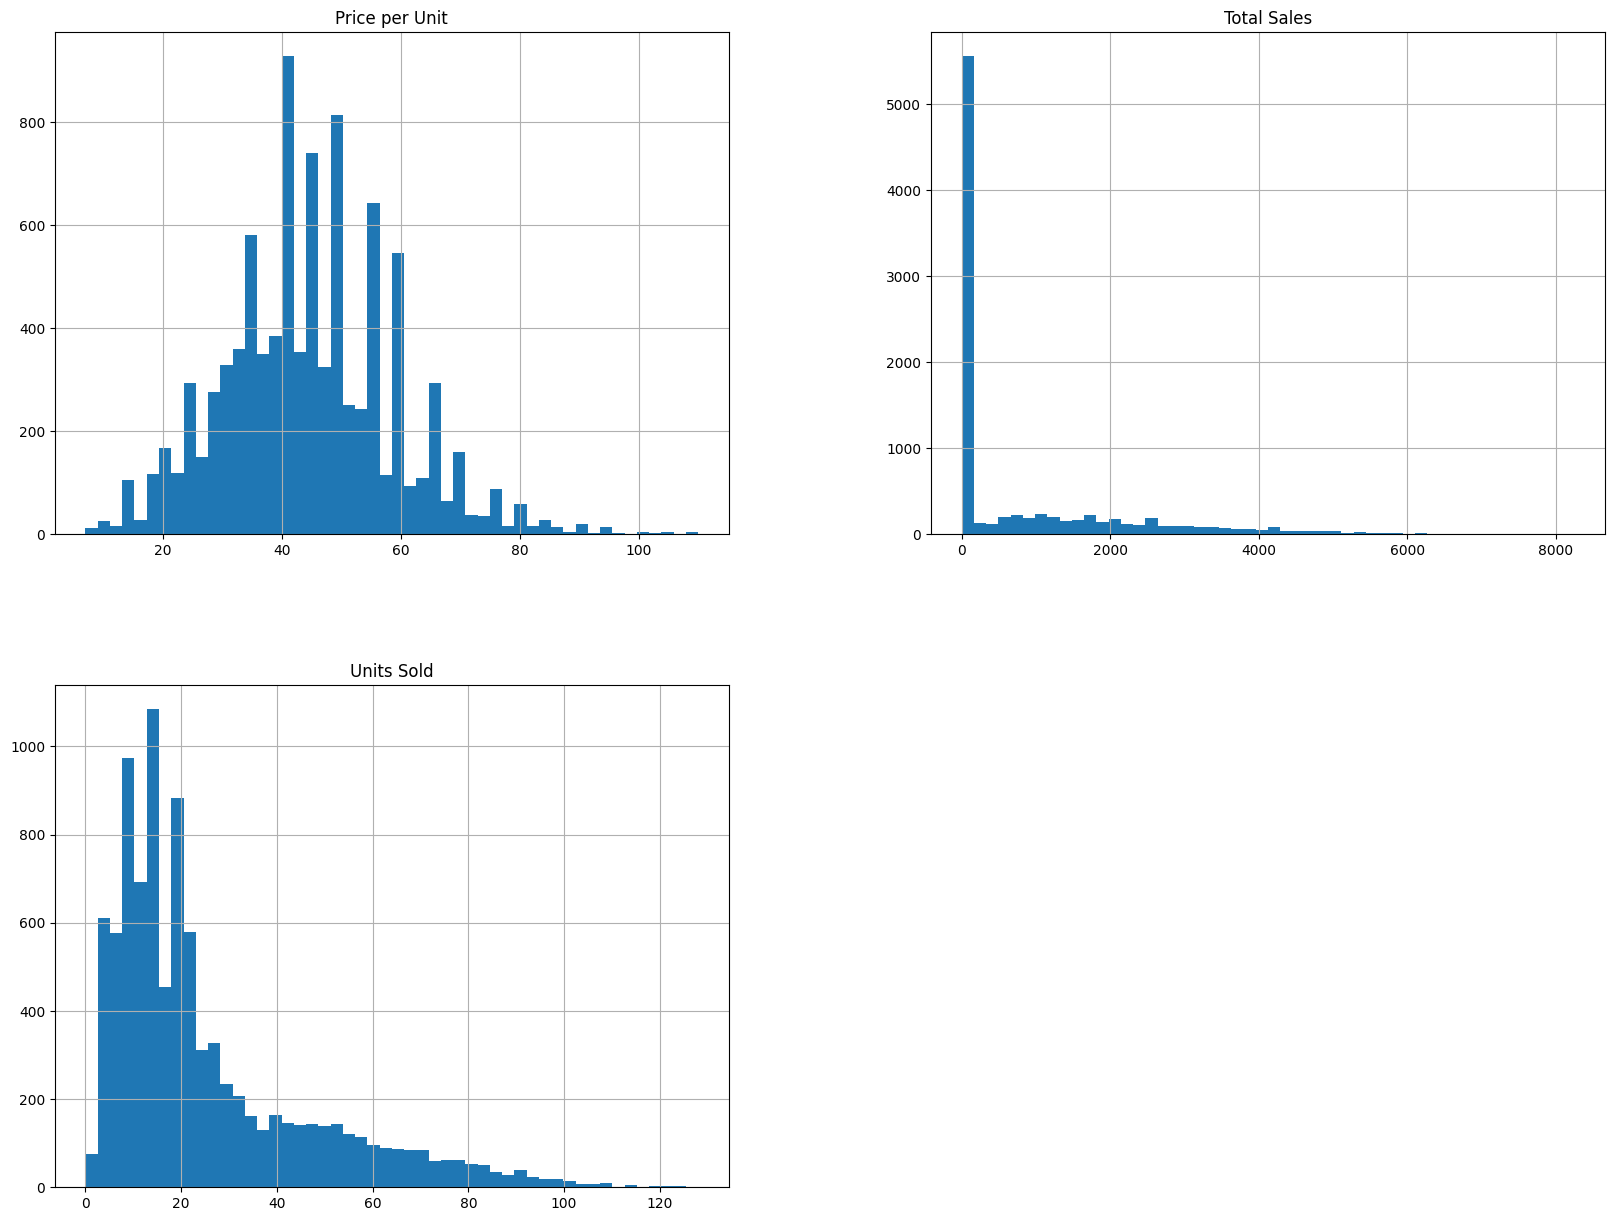

In [4]:
nike_sales.hist(bins=50 , figsize=(20,15)) 

In this graph we can see the distribution of each column, in the first graph of the Price per Units column we can see the shape of a bell, this could indicate that it complies with a normal distribution, however, in the other two it doesn't..  We could say that both comply with a Tweedie-type distribution.

*Verification with Shappiro test*

The Shapiro-Wilk test is a statistical test used to determine whether a sample of data comes from a population with a normal distribution. This test is widely used in statistics to verify the normality of a data set before applying certain parametric statistical analyzes that assume normality in the data.

In [5]:
#TEST SHAPIRO
y = nike_sales['Price per Unit']

_, p_value = stats.shapiro(y)
if p_value > 0.05:
    print("The data follows a normal distribution")
else:
    print("The data does not follow a normal distribution")

The data does not follow a normal distribution


c:\Users\alede\Desktop\TERCER_PROYECTO\entorno\lib\site-packages\scipy\stats\_axis_nan_policy.py:531: UserWarning: scipy.stats.shapiro: For N > 5000, computed p-value may not be accurate. Current N is 9360.
  res = hypotest_fun_out(*samples, **kwds)


* Atypical values

In the cleaning and processing notebook we have: Price per Unit: 57 outliers
Total Sales: 181
Units Sold: 116. These results are because they were determined by the z-score method. By seeing the graph and doing the test we change the way of detecting them. As the variables do not follow a normal distribution, the repair of outliers will be through the interquartile range method.

In [6]:
def detect_outliers(nike_sales, cols):
    dct = {}
    for col in cols:
        Q1 = nike_sales[col].quantile(0.25)
        Q3 = nike_sales[col].quantile(0.75)
        IQR = Q3 - Q1


        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR
       
        dct[col] = len(nike_sales[col][(nike_sales[col] < lower_bound) | (nike_sales[col] > upper_bound)])
    return dct

In [7]:
# Function to fix outliers
def fix_outliers(nike_sales, cols):
    for col in cols:
        Q1 = nike_sales[col].quantile(0.25)
        Q3 = nike_sales[col].quantile(0.75)
        IQR = Q3 - Q1

        lower_bound = Q1 - 1.5 * IQR
        upper_bound = Q3 + 1.5 * IQR

        nike_sales[col] = nike_sales[col].apply(lambda x: lower_bound if x < lower_bound else (upper_bound if x > upper_bound else x))
    return nike_sales

In [8]:
nike_sales = fix_outliers(nike_sales, ['Units Sold'])

In [9]:
detect_outliers(nike_sales, ['Units Sold'])

{'Units Sold': 0}

In [10]:
nike_sales['Units Sold'].unique()

array([71., 70., 55., 68., 63., 50., 60., 65., 53., 58., 45., 43., 48.,
       28., 13., 18., 23., 10., 20.,  8., 15., 25., 35., 33., 40., 38.,
       30.,  5.,  3., 47., 52., 62., 27., 22., 57., 17., 32., 67., 11.,
       12.,  6.,  9., 16., 19.,  7., 14.,  4., 24., 21., 26., 29.,  1.,
        2.,  0., 31., 34., 36., 42., 39., 37., 41.])

In [11]:
nike_sales['Units Sold'] = nike_sales['Units Sold'].astype(int)
print(nike_sales['Units Sold'].dtype)

int32


In [12]:
#save as new DF to use in Azure
nike_sales.to_csv('Nike_Ml', index=True)

1.2 Analyze product sales by State

In [13]:
nike_sales['State'].nunique()

48

In this Dataset there are 48 states of the USA. The states of Hawaii and Alaska are not included in it, so they will be taken into account for the analysis below.

In [14]:
# Diccionary of coordenates of the states
states = {
'New York': [42.6526, -73.7562],
    'Texas': [31.9686, -99.9018],
    'California': [36.7783, -119.4179],
    'Illinois': [40.6331, -89.3985],
    'Pennsylvania': [40.5908, -77.2098],
    'Nevada': [39.8762, -117.2241],
    'Colorado': [39.5501, -105.7821],
    'Washington': [47.7511, -120.7401],
    'Florida': [27.9944, -81.7603],
    'Minnesota': [46.7296, -94.6859],
    'Montana': [46.8797, -110.3626],
    'Tennessee': [35.5175, -86.5804],
    'Louisiana': [30.9843, -91.9623],
    'Virginia': [37.4316, -78.6569],
    'Wyoming': [43.0760, -107.2903],
    'Oregon': [43.8041, -120.5542],
    'Utah': [39.4192, -111.9507],
    'Iowa': [42.0329, -93.5815],
    'Michigan': [44.3148, -85.6024],
    'Missouri': [38.5739, -92.6034],
    'North Dakota': [47.5515, -101.0020],
    'Indiana': [40.5512, -85.6024],
    'Wisconsin': [44.2685, -89.6165],
    'Massachusetts': [42.4072, -71.3824],
    'New Hampshire': [43.1939, -71.5724],
    'Vermont': [44.5588, -72.5778],
    'Connecticut': [41.6032, -73.0877],
    'Delaware': [38.9108, -75.5277],
    'Maryland': [39.0458, -76.6413],
    'Rhode Island': [41.5801, -71.4774],
    'West Virginia': [38.5976, -80.4549],
    'New Jersey': [40.0583, -74.4057],
    'Maine': [45.2538, -69.4455],
    'Georgia': [32.1656, -82.9001],
    'Arizona': [34.0489, -111.0937],
    'Idaho': [44.0682, -114.7420],
    'New Mexico': [34.5199, -105.8701],
    'Ohio': [40.4173, -82.9071],
    'Kansas': [39.0119, -98.4842],
    'Nebraska': [41.4925, -99.9018],
    'South Dakota': [44.4443, -100.2263],
    'Alabama': [32.8067, -86.7911],
    'Mississippi': [32.7416, -89.6787],
    'Kentucky': [37.8393, -84.2700],
    'North Carolina': [35.7596, -79.0193],
    'South Carolina': [33.8361, -81.1637],
    'Oklahoma': [35.0078, -97.0929],
    'Arkansas': [34.7465, -92.2896]    
}

#Create a map using folium
map = folium.Map(location=[37.0902, -95.7129], zoom_start=4)
for state, coordinates in states.items():
    folium.Marker(location=coordinates, popup=states).add_to(map)

In [15]:
map

In [16]:
html_string = map._repr_html_()

with open('mi_mapa.html', 'w') as f:
    f.write(html_string)

In [17]:

#save the map in html
map.save('map.html')

In [18]:
#Save results in pkl to use in the app
with open('states.pkl', 'wb') as f:
    pickle.dump(states, f)

1.3 *Total Sale by State*

In [19]:
# Create a diccionary for sales by state
sales_by_state = {}
states_uniq = nike_sales['State'].unique()
for state in states_uniq:
    total_sales = nike_sales[nike_sales['State'] == state]['Total Sales'].sum()
    sales_by_state[state] = total_sales

# Imprimir las ventas totales por estado
for state, total_sales in sales_by_state.items():
    print(f'State: {state}, Total Sales: {total_sales}')

State: New York, Total Sales: 642317
State: Texas, Total Sales: 463613
State: California, Total Sales: 601768
State: Illinois, Total Sales: 97988
State: Pennsylvania, Total Sales: 103590
State: Nevada, Total Sales: 208586
State: Colorado, Total Sales: 209975
State: Washington, Total Sales: 263318
State: Florida, Total Sales: 592866
State: Minnesota, Total Sales: 73795
State: Montana, Total Sales: 157124
State: Tennessee, Total Sales: 180689
State: Louisiana, Total Sales: 237520
State: Virginia, Total Sales: 215753
State: Wyoming, Total Sales: 185783
State: Oregon, Total Sales: 213509
State: Utah, Total Sales: 96972
State: Iowa, Total Sales: 74249
State: Michigan, Total Sales: 186262
State: Missouri, Total Sales: 96846
State: North Dakota, Total Sales: 77361
State: Indiana, Total Sales: 88371
State: Wisconsin, Total Sales: 77286
State: Massachusetts, Total Sales: 110782
State: New Hampshire, Total Sales: 164133
State: Vermont, Total Sales: 143540
State: Connecticut, Total Sales: 115760


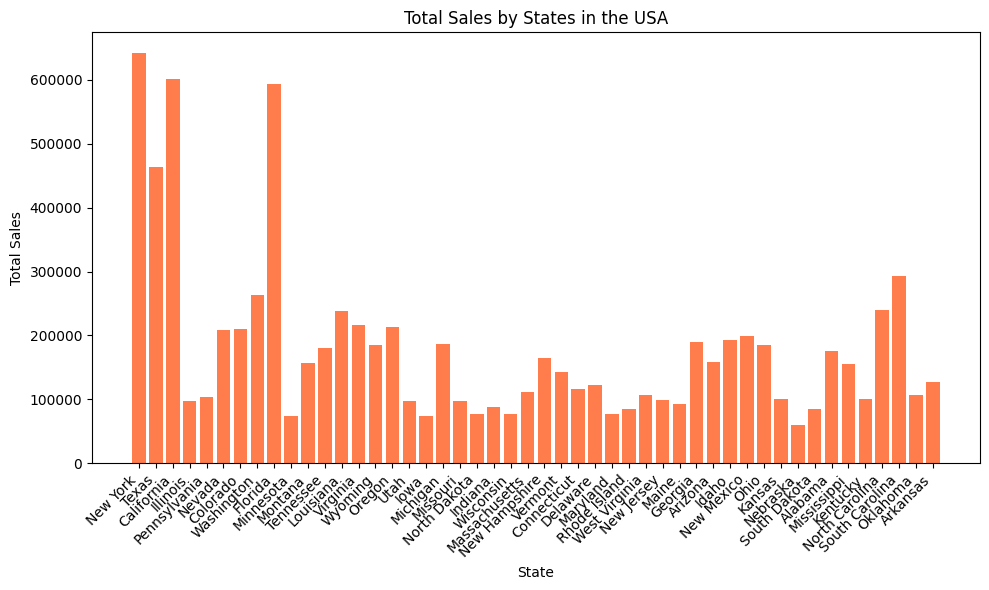

In [20]:
# Use the dictionary created to be able to graph
states_USA = list(sales_by_state.keys())
sales = list(sales_by_state.values())
plt.figure(figsize=(10, 6))
plt.bar(states_USA, sales, color='orangered', alpha=0.7)
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.title('Total Sales by States in the USA')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()

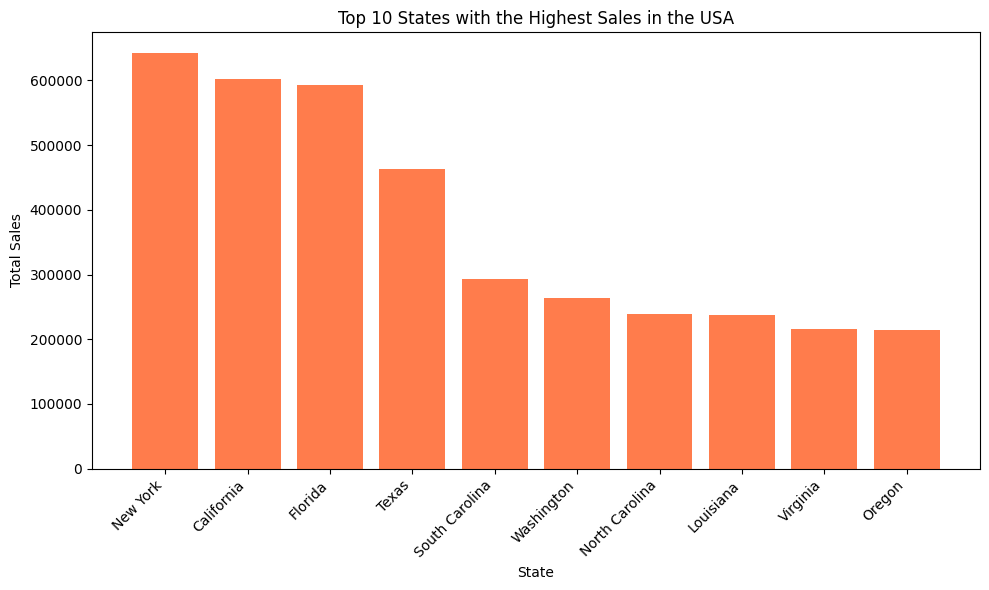

In [21]:
top_10_states = dict(sorted(sales_by_state.items(), key=lambda item: item[1], reverse=True)[:10])

plt.figure(figsize=(10, 6))
plt.bar(top_10_states.keys(), top_10_states.values(), color='orangered', alpha=0.7)
plt.xlabel('State')
plt.ylabel('Total Sales')
plt.title('Top 10 States with the Highest Sales in the USA')
plt.xticks(rotation=45, ha='right')  
plt.tight_layout()
plt.show()

In [22]:
# State with fewer sales
min_sales = min(sales)
min_state_index = sales.index(min_sales)
min_state = states_USA[min_state_index]

print(f"The state with the lowest sales is: {min_state} with total sales of {min_sales}.")


The state with the lowest sales is: Nebraska with total sales of 59301.


1.4 *Products sold by gender*

In [23]:
nike_sales['Product'].unique()

array(["Men's Street Footwear", "Men's Athletic Footwear",
       "Women's Street Footwear", "Women's Athletic Footwear",
       "Men's Apparel", "Women's Apparel"], dtype=object)

In [24]:
# Create a dictionary to store data by gender
men = {}
women = {}

# Iterate over each word
for word in nike_sales['Product']:
    separated = word.split()  # separate the word with split function
    if separated[0] == "Men's":
    
        if 'men' not in men:
            men['men'] = []
        # Append the product to the list of products for men
        men['men'].append(' '.join(separated[1:]))
    elif separated[0] == "Women's": #products for women
        if 'women' not in women:
            women['women'] = []
        women['women'].append(' '.join(separated[1:]))

# Print the products bought by men and women
print("Products bought by men:", men['men'])
print("Products bought by women:", women['women'])

Products bought by men: ['Street Footwear', 'Athletic Footwear', 'Apparel', 'Street Footwear', 'Athletic Footwear', 'Apparel', 'Street Footwear', 'Athletic Footwear', 'Apparel', 'Street Footwear', 'Athletic Footwear', 'Apparel', 'Street Footwear', 'Athletic Footwear', 'Apparel', 'Street Footwear', 'Athletic Footwear', 'Apparel', 'Street Footwear', 'Athletic Footwear', 'Apparel', 'Street Footwear', 'Athletic Footwear', 'Apparel', 'Street Footwear', 'Athletic Footwear', 'Apparel', 'Apparel', 'Street Footwear', 'Athletic Footwear', 'Apparel', 'Street Footwear', 'Athletic Footwear', 'Apparel', 'Street Footwear', 'Athletic Footwear', 'Apparel', 'Street Footwear', 'Athletic Footwear', 'Apparel', 'Street Footwear', 'Athletic Footwear', 'Apparel', 'Street Footwear', 'Athletic Footwear', 'Apparel', 'Street Footwear', 'Athletic Footwear', 'Apparel', 'Street Footwear', 'Athletic Footwear', 'Apparel', 'Street Footwear', 'Athletic Footwear', 'Apparel', 'Street Footwear', 'Athletic Footwear', 'Appar

In [25]:
# Use the dictionary created to be able to graph
total_men_products = sum(len(products) for products in men.values())
total_women_products = sum(len(products) for products in women.values())
fig = px.histogram(x=['Men', 'Women'], y=[total_men_products, total_women_products], color=['Men', 'Women'], color_discrete_map={'Men': 'red', 'Women': 'orangered'})
fig.show()

This database shows that the total amount of Nike products sold is the same for men and women.

1.5 *Price behavior over time*

In [26]:
nike_sales['Invoice Date'] = pd.to_datetime(nike_sales['Invoice Date'], format='%d-%m-%Y')

In [27]:
nike_sales['Invoice Date'].min()

Timestamp('2020-01-01 00:00:00')

In [28]:
nike_sales['Invoice Date'].max()

Timestamp('2021-12-31 00:00:00')

In [29]:
fig = px.scatter(x=nike_sales['Invoice Date'], y=nike_sales['Price per Unit'] , 
                 title='Price behavior over time',
                 labels={'x': 'Date', 'y': 'Price'})
fig.show()

In the column 'Invoice Date' it is observed that sales begin on 2020-01-01 and end on '2021-12-31'. The graph shows how the price has reached its highest peak in the month of June and July 2021.

1.6. *Analysis of the payment method*

In [30]:
nike_sales['Sales Method'].unique()

array(['In-store', 'Outlet', 'Online'], dtype=object)

Text(0, 0.5, 'Total Sales')

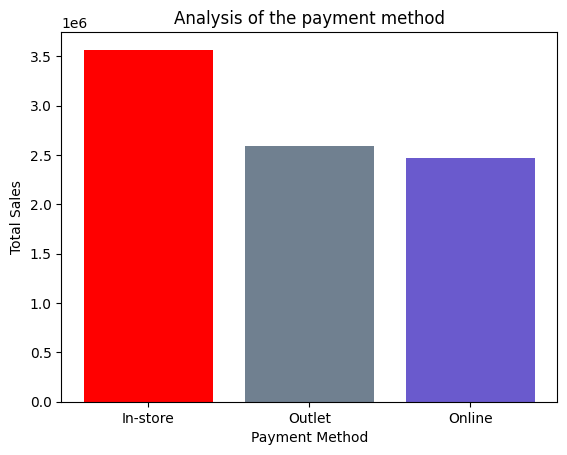

In [31]:
#Define the sales method
store_sales = nike_sales[nike_sales['Sales Method'] == 'In-store']
outlet_sales = nike_sales[nike_sales['Sales Method'] == 'Outlet']
online_sales = nike_sales[nike_sales['Sales Method']== 'Online']
#Sum the total sales for each method
total_store_sales = store_sales['Total Sales'].sum()
total_outlet_sales = outlet_sales['Total Sales'].sum()
total_online_sales = online_sales['Total Sales'].sum()
methods = ['In-store', 'Outlet', 'Online']
sales = [total_store_sales, total_outlet_sales, total_online_sales]
colors = ['red', 'slategrey' , 'slateblue'] 
plt.bar(methods, sales, color=colors)
plt.title('Analysis of the payment method')
plt.xlabel('Payment Method')
plt.ylabel('Total Sales')

The most used payment method is in store, while outlet and online are almost equal.

1.7 *Behavior of total sales over time*

In [32]:
nike_sales['Month'] = nike_sales['Invoice Date'].dt.to_period('M').astype(str)
month = nike_sales['Month']

In [33]:
fig = px.bar(x=nike_sales['Month'], y=nike_sales['Total Sales'], title='Total Sales over Time')

# Personalizar el estilo del gráfico
fig.update_traces(marker_color='blue') 
fig.update_layout(xaxis=dict(tickangle=45), plot_bgcolor='white', paper_bgcolor='white')
fig.show()

1.8 *Classification by product type*

In [34]:
nike_sales['Product'].unique()

array(["Men's Street Footwear", "Men's Athletic Footwear",
       "Women's Street Footwear", "Women's Athletic Footwear",
       "Men's Apparel", "Women's Apparel"], dtype=object)

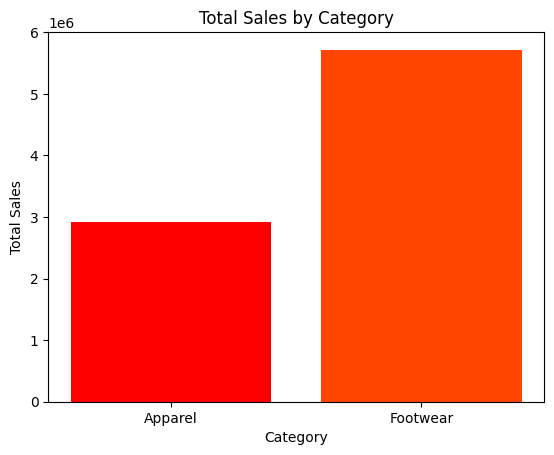

In [35]:
#Separate the products by category
apparel = nike_sales[nike_sales['Product'].str.contains('Apparel')]
footwear = nike_sales[nike_sales['Product'].str.contains('Footwear')]
products_category = ['Apparel', 'Footwear']
total_sales_category = [apparel['Total Sales'].sum(), footwear['Total Sales'].sum()]
colors = ['red', 'orangered']
plt.bar(products_category, total_sales_category, color=colors)
plt.title('Total Sales by Category')
plt.xlabel('Category')
plt.ylabel('Total Sales')
plt.show()

# 2. Analyze the variables of other DF to deepen the analysis of sales at Nike

Explore the variables of the dataset `Nike_product` , `adidas vs nike`, `location`. 

In [36]:
nike_product = pd.read_csv(r"C:\Users\alede\Desktop\TERCER_PROYECTO\Df_limpios\nike_product.csv")
adidas_nike = pd.read_csv(r"C:\Users\alede\Desktop\TERCER_PROYECTO\Df_limpios\adidas_nike.csv")
location = pd.read_csv(r"C:\Users\alede\Desktop\TERCER_PROYECTO\Df_limpios\Location.cvs")

In [37]:
nike_product.columns

Index(['Unnamed: 0', 'Product Name', 'Product ID', 'Sale Price', 'Description',
       'Rating', 'Reviews', 'Images', 'Last Visited'],
      dtype='object')

In [38]:
total_product = nike_product['Product Name'].value_counts()
total_product.sum()

643

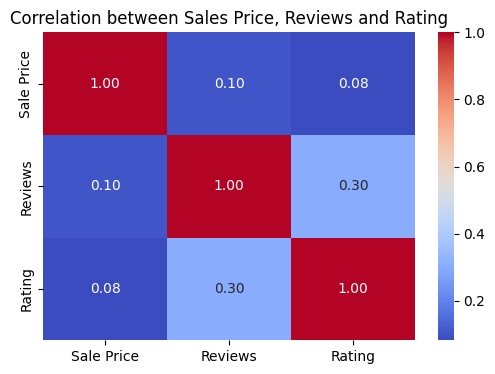

In [39]:
correlation_matrix = nike_product[['Sale Price', 'Reviews', 'Rating']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Sales Price, Reviews and Rating')
plt.show()

0.30: This value indicates a moderate correlation between the 'Reviews' and 'Rating' variables. A correlation of 0.30 suggests that there is a moderate relationship between the number of reviews and ratings. In other words, higher ratings tend to be associated with more reviews, and vice versa.

In [40]:
fig = px.bar(nike_product, x='Rating', y='Reviews', title='Rating and reviews')
fig.show()

*Product with the most Review and highest Rating*

In [41]:
review_5_products = nike_product[nike_product['Reviews'] == 36].head() 
review_5_products

,Unnamed: 0,Product Name,Product ID,Sale Price,Description,Rating,Reviews,Images,Last Visited
516,516,Nike Air Force 1 Sage Low,AR5339-002,8995,"Taking both height and craft to new levels, th...",4.5,36,"[""https://c.static-nike.com/a/images/t_PDP_172...",2020-04-13 15:36:40


In [42]:
row_516 = nike_product.iloc[516]
print(row_516)

Unnamed: 0                                                    516
Product Name                            Nike Air Force 1 Sage Low
Product ID                                             AR5339-002
Sale Price                                                   8995
Description     Taking both height and craft to new levels, th...
Rating                                                        4.5
Reviews                                                        36
Images          ["https://c.static-nike.com/a/images/t_PDP_172...
Last Visited                                  2020-04-13 15:36:40
Name: 516, dtype: object


In [43]:
rating_5_products = nike_product[nike_product['Rating'] == 5.0].head(3) 
rating_5_products 
    

,Unnamed: 0,Product Name,Product ID,Sale Price,Description,Rating,Reviews,Images,Last Visited
7,7,Nike Free Metcon 3,CJ0861-017,9995,The Nike Free Metcon 3 combines Nike Free flex...,5.0,1,No Image,2020-04-13 15:27:59
9,9,Nike Air Max 270 React ENG,CK2595-500,14995,The Nike Air Max 270 React ENG combines a full...,5.0,2,"[""https://static.nike.com/a/images/t_PDP_1728_...",2020-04-13 15:27:59
10,10,Nike Air Max 90,CD0490-104,9995,"Clean lines, versatile and timeless—the people...",5.0,9,"[""https://static.nike.com/a/images/t_PDP_1728_...",2020-04-13 15:28:00


In [44]:


image_url = "https://static.nike.com/a/images/t_PDP_1728_v1/0b4520d4-f02a-4ba4-bbb0-aabcd939f835/air-max-270-react-eng-shoe-S0gdwR.jpg"

response = requests.get(image_url)
if response.status_code == 200:
    
    image_data = BytesIO(response.content)
    
    image = Image.open(image_data)

    image.save("air_max_270_react.jpg")
    print("La imagen se ha descargado correctamente como 'air_max_270_react.jpg'")
else:
    print("Hubo un problema al descargar la imagen. Código de estado:", response.status_code)


La imagen se ha descargado correctamente como 'air_max_270_react.jpg'


*Image of the product with the most Review and highest Rating*

In [45]:


image_url = "https://static.nike.com/a/images/t_PDP_1728_v1/0b4520d4-f02a-4ba4-bbb0-aabcd939f835/air-max-270-react-eng-shoe-S0gdwR.jpg"

response = requests.get(image_url)
if response.status_code == 200:
    
    image_data = BytesIO(response.content)
    
    image = Image.open(image_data)

    image.save("air_max_270_react.jpg")
    print("La imagen se ha descargado correctamente como 'air_max_270_react.jpg'")
else:
    print("Hubo un problema al descargar la imagen. Código de estado:", response.status_code)

La imagen se ha descargado correctamente como 'air_max_270_react.jpg'


C:\Users\Public\Documents\Wondershare\CreatorTemp\ipykernel_8900\432645763.py:1: UserWarning:



`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751




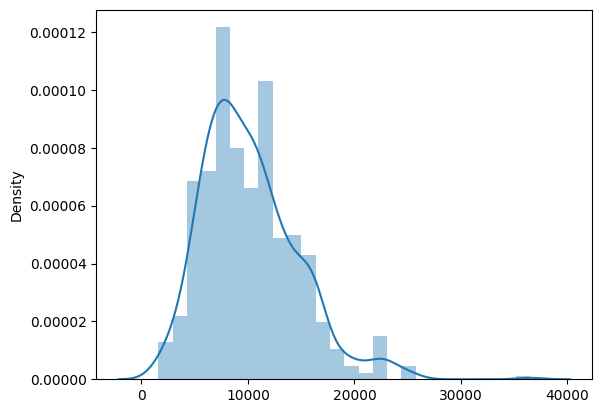

In [46]:
sns.distplot(x=nike_product['Sale Price'], kde=True)
plt.show()

2.1. *5 most expensive products*

In [47]:
expensive = nike_product.nlargest(5, 'Sale Price')
print(expensive[['Product Name', 'Sale Price', 'Rating']])

                               Product Name  Sale Price  Rating
523         Nike Air VaporMax Flyknit 2 LXX       36500     0.0
68    Nike Mercurial Superfly 7 Elite SE FG       24995     0.0
306  Nike Mercurial Superfly 7 Elite MDS FG       24995     5.0
524   Nike Mercurial Superfly 7 Elite SE FG       24995     0.0
539  Nike Mercurial Superfly 7 Elite MDS FG       24995     5.0


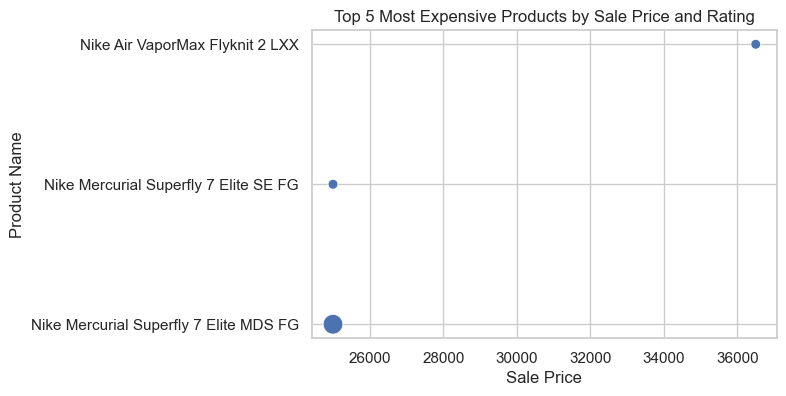

In [48]:
sns.set(style="whitegrid")
plt.figure(figsize=(6,4))
sns.scatterplot(x='Sale Price', y='Product Name', size='Rating', data=expensive, sizes=(50, 200), legend=False)
plt.xlabel('Sale Price')
plt.ylabel('Product Name')
plt.title('Top 5 Most Expensive Products by Sale Price and Rating')
plt.show()

Only two products are seen in the graph because they are the ones with a rating = 5.

2.2. *The 5 cheapest*

In [49]:
cheapest = nike_product.nsmallest(5, 'Sale Price')
print(cheapest[['Product Name', 'Sale Price', 'Rating']])

         Product Name  Sale Price  Rating
154  Nike Kawa Shower        1595     4.5
309    Nike Solarsoft        1595     3.8
402  Nike Kawa Shower        1595     0.0
30       Jordan Break        1995     4.2
234    Nike Bella Kai        1995     0.0


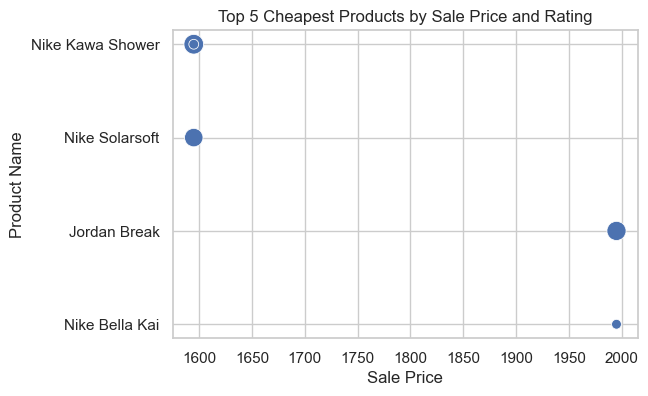

In [50]:
sns.set(style="whitegrid")
plt.figure(figsize=(6, 4))
sns.scatterplot(x='Sale Price', y='Product Name', size='Rating', data=cheapest, sizes=(50, 200), legend=False)
plt.xlabel('Sale Price')
plt.ylabel('Product Name')
plt.title('Top 5 Cheapest Products by Sale Price and Rating')
plt.show()

2.3. *Rating by products*

In [51]:
nike_product['Rating'].max()

5.0

the highest rating is 5

In [52]:
rating_prod = nike_product.nlargest(5, 'Rating')
print(rating_prod[['Product Name', 'Rating']])

                  Product Name  Rating
7           Nike Free Metcon 3     5.0
9   Nike Air Max 270 React ENG     5.0
10             Nike Air Max 90     5.0
22         Air Jordan XXXIV PF     5.0
31                 LeBron 7 QS     5.0


In [53]:
# the products with the lowest rating
low_rating = nike_product.nsmallest(5, 'Rating')
print(low_rating[['Product Name', 'Rating']])

                     Product Name  Rating
0  Nike Air Force 1 '07 Essential     0.0
1            Nike Air Force 1 '07     0.0
2    Nike Air Force 1 Sage Low LX     0.0
3             Nike Air Max Dia SE     0.0
4             Nike Air Max Verona     0.0


2.4 *Adidas vs Nike*

In this part of the analysis, the online sales between the two brands are analyzed and compared: Nike and Adidas. Additionally, customer perception, loyalty and which brand offers the greatest variety of products for online sale are analyzed.

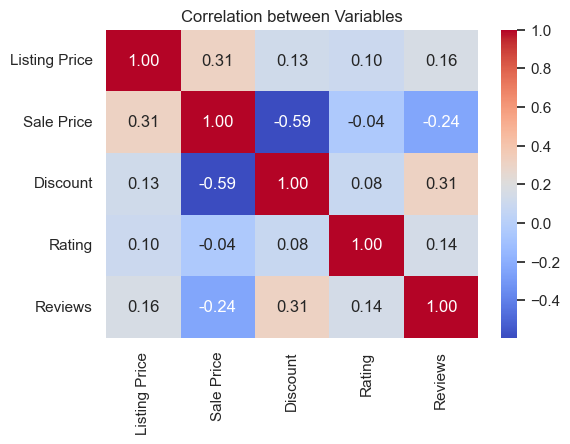

In [54]:
correlation_matrix = adidas_nike[['Listing Price', 'Sale Price', 'Discount',  'Rating', 'Reviews']].corr()
plt.figure(figsize=(6, 4))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation between Variables')
plt.show()

A greater relationship is observed between listing price and price. Between Discount and Review.

In [55]:
adidas_nike.columns

Index(['Unnamed: 0', 'Product Name', 'Listing Price', 'Sale Price', 'Discount',
       'Brand', 'Description', 'Rating', 'Reviews', 'Last Visited'],
      dtype='object')

In [56]:
# delete column that we are not going to use
adidas_nike.drop(columns=['Unnamed: 0'], axis=1, inplace=True)


2.5. *Analysis of brand perception*

According to the correlation analysis there is a low relationship but now we will go deeper between the brands

In [57]:
#Separete the products by brand
adidas_nike_data = adidas_nike[adidas_nike['Brand'].str.contains('Adidas|Nike')]

In [58]:
#Analyze the price variable and the reviews of both brands.
cheapest_p_adidas = adidas_nike_data[adidas_nike_data['Brand'].str.contains('Adidas')].nsmallest(5, 'Sale Price')
print(cheapest_p_adidas[['Reviews', 'Sale Price']])

      Reviews  Sale Price
2044       36         449
147        20         499
2046        1         499
2420       22         499
2493       87         499


In [59]:
cheapest_p_nike = adidas_nike_data[adidas_nike_data['Brand'].str.contains('Nike')].nsmallest(5, 'Sale Price')
print(cheapest_p_nike[['Reviews', 'Sale Price']])

      Reviews  Sale Price
2779        6        1595
2934        5        1595
3027        0        1595
2655        5        1995
2859        0        1995


Comparing the prices and number of Reviews (we don't know if they are good or bad reviews) we observe that Adidas has lower prices and more reviews than Nike.

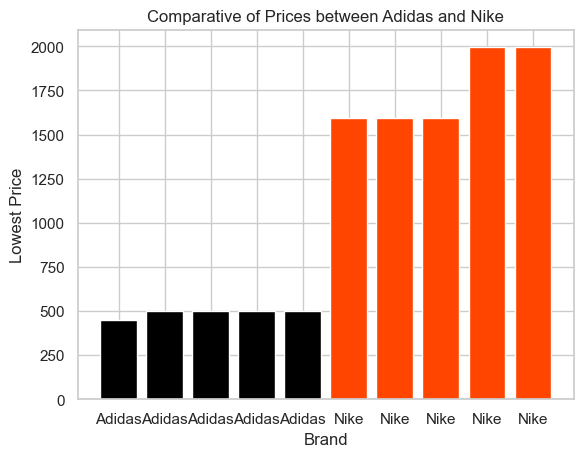

In [60]:
# Graph the results
#Step 1: Creat a list
brands = ['Adidas'] * len(cheapest_p_adidas) + ['Nike'] * len(cheapest_p_nike) 
prices = cheapest_p_adidas['Sale Price'].tolist() + cheapest_p_nike['Sale Price'].tolist()
#Graph
plt.bar(range(len(brands)), prices, color=['black'] * len(cheapest_p_adidas) + ['orangered'] * len(cheapest_p_nike))
plt.xticks(range(len(brands)), brands)
plt.title('Comparative of Prices between Adidas and Nike')
plt.xlabel('Brand')
plt.ylabel('Lowest Price')
plt.show()


In [61]:
adidas_nike['Brand'].unique()

array(['Adidas Adidas ORIGINALS', 'Adidas ORIGINALS', 'Adidas CORE / NEO',
       'Adidas SPORT PERFORMANCE', 'Nike'], dtype=object)

In [62]:
#Separate the words by brand
brand= adidas_nike['Brand']
separated = brand.str.split(r'(?i)\b(adidas|nike)\b', expand=True)

separated = separated.rename(columns={1: 'Brand'})
separated.drop(columns= [0,2,3,4], axis=1 , inplace=True)
separated.tail()

,Brand
3263,Nike
3264,Nike
3265,Nike
3266,Nike
3267,Nike


In [63]:
#Transform the column into a numerical variable
encoder = LabelEncoder()
separated['Brand'] = encoder.fit_transform(separated['Brand'])
print(separated)


      Brand
0         0
1         0
2         0
3         0
4         0
...     ...
3263      1
3264      1
3265      1
3266      1
3267      1

[3268 rows x 1 columns]


Now 0 is Adidas and 1 is Nike

In [64]:
#change the name of the encoded column and add this df to adidas_nike
separated = separated.rename(columns={'Brand': 'Brand_numeric'})
adidas_nike_ = pd.concat([separated, adidas_nike], axis=1)
adidas_nike_.columns


Index(['Brand_numeric', 'Product Name', 'Listing Price', 'Sale Price',
       'Discount', 'Brand', 'Description', 'Rating', 'Reviews',
       'Last Visited'],
      dtype='object')

In [65]:
adidas_average = adidas_nike_[adidas_nike_['Brand_numeric'] == 0]
adidas_average_price = adidas_average['Sale Price'].mean()
print("The average price of Adidas products is:", adidas_average_price)

The average price of Adidas products is: 5135.00419047619


In [66]:
nike_average = adidas_nike_[adidas_nike_['Brand_numeric'] == 1]
nike_average_price = nike_average['Sale Price'].mean()
print("The average price of Nike products is:", nike_average_price)

The average price of Nike products is: 10213.676516329704


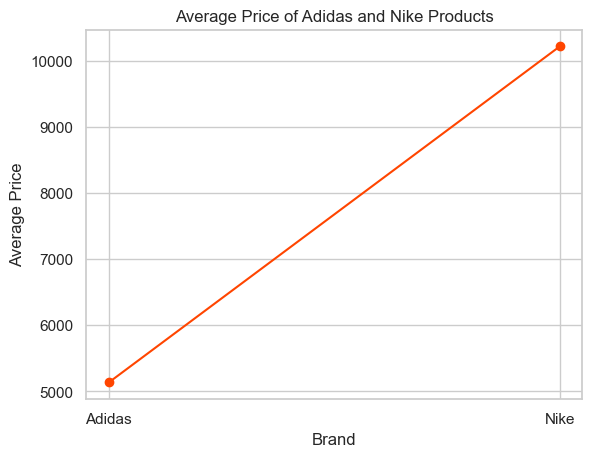

In [67]:
plt.plot([adidas_average_price, nike_average_price], marker='o', linestyle='-', color='orangered')
plt.title('Average Price of Adidas and Nike Products')
plt.xlabel('Brand')
plt.ylabel('Average Price')
plt.grid(True)
plt.xticks([0, 1], ['Adidas', 'Nike'])  # Agregar etiquetas para los ticks del eje x
plt.show()

2.6. *Analysis of customer loyalty perception*

We are going to analyze which of the brands offers the most discount

In [68]:
nike_discount = adidas_nike_[adidas_nike_['Brand_numeric'] == 1]
nike_dis_max = nike_discount['Discount'].max()
print("The maximum discount that Nike makes is:" , nike_dis_max)

The maximum discount that Nike makes is: 0


In [69]:
adidas_discount = adidas_nike_[adidas_nike_['Brand_numeric'] == 0]
adidas_dis_max = adidas_discount['Discount'].max()
print("The maximum discount that Adidas makes is:" , adidas_dis_max)

The maximum discount that Adidas makes is: 60


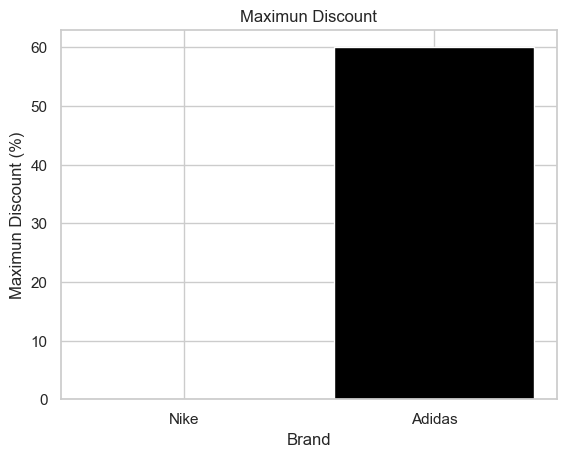

In [70]:
#Graph this results
brands = ['Nike', 'Adidas']
max_discounts = [nike_dis_max, adidas_dis_max]
# Bar graph
plt.bar(brands, max_discounts, color=['orangered', 'black'])
plt.title('Maximun Discount')
plt.xlabel('Brand')
plt.ylabel('Maximun Discount (%)')
plt.show()

Which of the two brands has the most visits in E-commerce?

In [71]:
#Verification of the format in the column
adidas_nike_['Last Visited'].dtype

dtype('O')

In [72]:
#Convert to date format
adidas_nike_['Last Visited'] = pd.to_datetime(adidas_nike_['Last Visited'])

In [73]:
visit_ad = adidas_nike_[adidas_nike_['Brand_numeric'] == 0]
adidas_visit_max = visit_ad['Last Visited'].value_counts()
print("Adidas has:" , adidas_visit_max, "total visits")

Adidas has: Last Visited
2020-04-13 15:06:32    38
2020-04-13 15:06:28    38
2020-04-13 15:06:26    36
2020-04-13 15:06:35    34
2020-04-13 15:06:45    34
                       ..
2020-04-13 15:06:16    11
2020-04-13 15:07:33    11
2020-04-13 15:06:15     9
2020-04-13 15:06:17     7
2020-04-13 15:06:14     1
Name: count, Length: 106, dtype: int64 total visits


In [74]:
visit_nike = adidas_nike_[adidas_nike_['Brand_numeric'] == 1]
nike_visit_max = visit_nike['Last Visited'].value_counts()
print("Nike has:" , nike_visit_max, "total visits")

Nike has: Last Visited
2020-04-13 15:32:44    9
2020-04-13 15:28:16    9
2020-04-13 15:32:35    9
2020-04-13 15:32:40    8
2020-04-13 15:32:39    8
                      ..
2020-04-13 15:30:10    1
2020-04-13 15:30:04    1
2020-04-13 15:37:03    1
2020-04-13 15:37:09    1
2020-04-13 15:42:57    1
Name: count, Length: 212, dtype: int64 total visits


Regarding the result: "length:106" indicates that the Series has a length of 106, which means that there are 106 elements in the Series. This implies that there are 106 unique dates in which visits to the brand "adidas" were recorded in the DataFrame and change in nike length:212. This means that Nike had more visits than Adidas

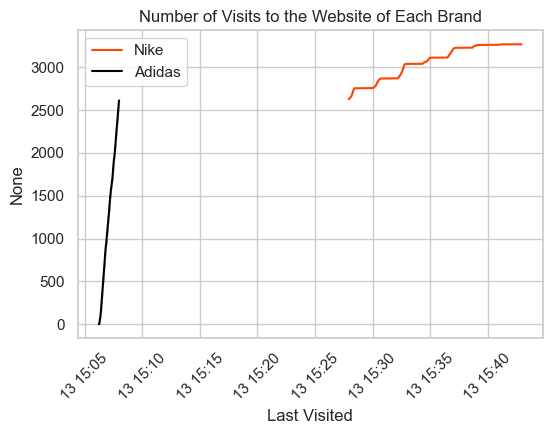

In [75]:
#Graph of the number of visits to the website of each brand
plt.figure(figsize=(6,4))
sns.lineplot(x='Last Visited', y= visit_nike.index, data=visit_nike, label='Nike', color='orangered')
sns.lineplot(x='Last Visited', y=visit_ad.index, data=visit_ad, label='Adidas', color= 'black')
plt.xticks(rotation=45)
plt.title('Number of Visits to the Website of Each Brand')
plt.legend()
plt.show()

This graph shows the number of visits to the brands "Nike" and "Adidas" over time.

2.7. *Analyze the Rating of each brand's products*

In [76]:
##Let's analyze the highest rating of each brand
adidas_rating= adidas_nike_[adidas_nike_['Brand_numeric'] == 0]
rating_max = adidas_rating['Rating'].max()
print("The highest rating of Adidas is:", rating_max)

The highest rating of Adidas is: 5.0


In [77]:
total_rating_5 = (adidas_rating['Rating'] == 5.0).sum()
print("The total number of products with a rating of 5.0 is:", total_rating_5)

The total number of products with a rating of 5.0 is: 87


In [78]:
nike_rating= adidas_nike_[adidas_nike_['Brand_numeric'] == 1]
rating_max_nike = nike_rating['Rating'].max()
print("The highest rating of Nike is:", rating_max_nike)

The highest rating of Nike is: 5.0


In [79]:
total_rating_5_nike = (nike_rating['Rating'] == 5.0).sum()
print("The total number of Nike products with a rating of 5.0 is:", total_rating_5_nike)

The total number of Nike products with a rating of 5.0 is: 120


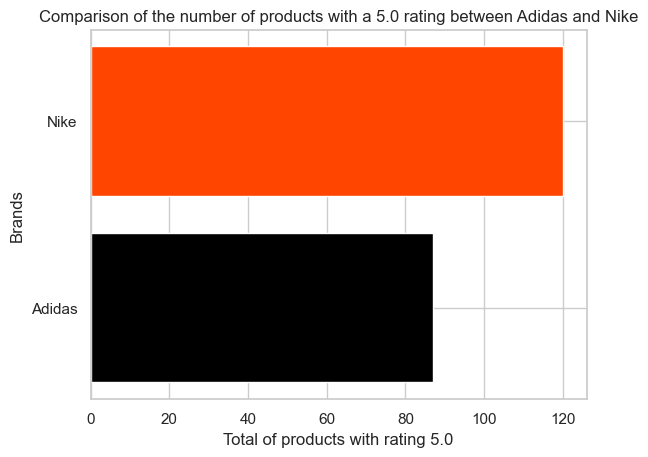

In [80]:
#Horizontal bar graph
brands = ['Adidas', 'Nike']
total_rating_5 = [total_rating_5, total_rating_5_nike]
fig, ax = plt.subplots()
ax.barh(brands, total_rating_5, color=['black', 'orangered'])
ax.set_xlabel('Total of products with rating 5.0')
ax.set_ylabel('Brands')
ax.set_title('Comparison of the number of products with a 5.0 rating between Adidas and Nike')
plt.show()


With this we know which brand has more highly rated products.

2.8. *Analysis of Nike factories*


Location of Nike factories around the world

In [81]:
fabric =location['Country / Region'].unique()
print(fabric)

['USA' 'Vietnam' 'Jordan' 'India' 'Georgia' 'Turkey' 'China' 'Brazil'
 'Nicaragua' 'Cambodia' 'Moldova' 'Japan' 'Honduras' 'Italy' 'South Korea'
 'Indonesia' 'Sri Lanka' 'Thailand' 'Taiwan' 'Guatemala' 'Argentina'
 'El Salvador' 'Mexico' 'Egypt' 'Israel' 'Bulgaria' 'Croatia' 'Malaysia'
 'Pakistan' 'Spain' 'Canada' 'Netherlands' 'Bosnia' 'Lithuania'
 'Philippines' 'South Africa']


In [82]:
location['Country / Region'].value_counts()

Country / Region
Vietnam         152
China           143
Indonesia        53
Taiwan           30
Thailand         28
USA              26
Sri Lanka        24
Cambodia         19
South Korea      19
Italy            11
Brazil           10
Japan             9
India             9
Egypt             8
Mexico            7
Turkey            6
Pakistan          6
Malaysia          5
Jordan            5
El Salvador       4
Guatemala         4
Georgia           4
Honduras          4
Argentina         3
Moldova           2
Philippines       2
Israel            1
Bulgaria          1
Croatia           1
Nicaragua         1
Spain             1
Canada            1
Netherlands       1
Bosnia            1
Lithuania         1
South Africa      1
Name: count, dtype: int64

In [83]:
# we are going to use the folium maps
map_factory = folium.Map(location=[0, 0], zoom_start=2)
#Make a diccionary with coordinates
coordinates = {
    'USA': [37.0902, -95.7129],
    'Vietnam': [14.0583, 108.2772],
    'Jordan': [30.5852, 36.2384],
    'India': [20.5937, 78.9629],
    'Georgia': [42.3154, 43.3569],
    'Turkey': [38.9637, 35.2433],
    'China': [35.8617, 104.1954],
    'Brazil': [-14.2350, -51.9253],
    'Nicaragua': [12.8654, -85.2072],
    'Cambodia': [12.5657, 104.9910],
    'Moldova': [47.4116, 28.3699],
    'Japan': [36.2048, 138.2529],
    'Honduras': [15.199999, -86.241905],
    'Italy': [41.8719, 12.5674],
    'South Korea': [35.9078, 127.7669],
    'Indonesia': [-0.7893, 113.9213],
    'Sri Lanka': [7.8731, 80.7718],
    'Thailand': [15.8700, 100.9925],
    'Taiwan': [23.6978, 120.9605],
    'Guatemala': [15.7835, -90.2308],
    'Argentina': [-38.4161, -63.6167],
    'El Salvador': [13.7942, -88.8965],
    'Mexico': [23.6345, -102.5528],
    'Egypt': [26.8206, 30.8025],
    'Israel': [31.0461, 34.8516],
    'Bulgaria': [42.7339, 25.4858],
    'Croatia': [45.1000, 15.2000],
    'Malaysia': [4.2105, 101.9758],
    'Pakistan': [30.3753, 69.3451],
    'Spain': [40.4637, -3.7492],
    'Canada': [56.1304, -106.3468],
    'Netherlands': [52.1326, 5.2913],
    'Bosnia': [43.9159, 17.6791],
    'Lithuania': [55.1694, 23.8813],
    'Philippines': [12.8797, 121.7740],
    'South Africa': [-30.5595, 22.9375]
}
for country, coord in coordinates.items():
    folium.Marker(location=coord, popup=country).add_to(map_factory)
    

In [84]:
map_factory

Types of factories

In [85]:
location['Factory Type'].unique()

array(['FINISHED GOODS', 'MATERIALS', 'FINISHED GOODS - COMPONENTS'],
      dtype=object)

FINISHED GOODS: These factories are dedicated to the production of final products ready to be sold and used by consumers. 

In [86]:
#Filter from the factory types column only those that are Finished goods
finish_prod = location[location['Factory Type'] == 'FINISHED GOODS']
country_finish = finish_prod['Country / Region']
num_countries_finished_goods = country_finish.nunique() #nunique going to count unique values

print("Number of countries with type factories 'FINISHED GOODS':", num_countries_finished_goods)


Number of countries with type factories 'FINISHED GOODS': 36


MATERIALS: These factories focus on the production of materials or components that are used in the manufacture of final products.

In [87]:
#Filter from the factory types column only those that are Materials
material_fab = location[location['Factory Type'] == 'MATERIALS']
country_material = material_fab['Country / Region']
num_countries_material = country_material.nunique() #nunique going to count unique values

print("Number of countries with type factories 'Materials':", num_countries_material)

Number of countries with type factories 'Materials': 14


FINISHED GOODS - COMPONENTS: These factories may be involved in the production of specific components that are used in the manufacturing of final products.

In [88]:
#Filter from the factory types column only those that are 'FINISHED GOODS - COMPONENTS'
compon_fab = location[location['Factory Type'] == 'FINISHED GOODS - COMPONENTS']
country_compo = compon_fab['Country / Region']
num_countries_comp = country_compo.nunique() #nunique going to count unique values

print("Number of countries with type factories FINISHED GOODS - COMPONENTS:", num_countries_comp)

Number of countries with type factories FINISHED GOODS - COMPONENTS: 11


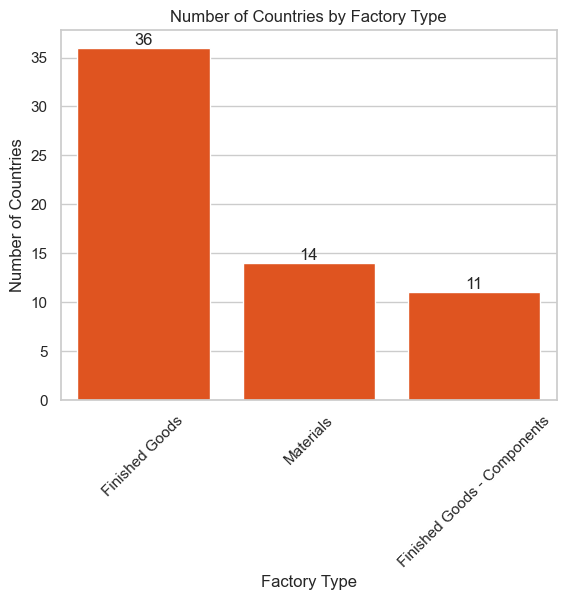

In [89]:
num_countries = [num_countries_finished_goods, num_countries_material, num_countries_comp]
type_fab = ['Finished Goods', 'Materials', 'Finished Goods - Components']
sns.barplot(x=type_fab, y=num_countries, color='orangered')
plt.xticks(rotation=45)
for index, value in enumerate(num_countries):
    plt.text(index, value, str(value), ha='center', va='bottom')
plt.title('Number of Countries by Factory Type')
plt.xlabel('Factory Type')
plt.ylabel('Number of Countries')
plt.show()
    

In [90]:
nike_sales['Retailer'].unique()

array(['Foot Locker', 'Walmart', 'Sports Direct', 'West Gear', "Kohl's",
       'Amazon'], dtype=object)

In [91]:
finish_prod_ = location[location['Factory Type'] == 'FINISHED GOODS']
usa_fab = finish_prod_[finish_prod_['Country / Region'] == 'USA']
num_usa_fabrics = usa_fab['Factory Name'].nunique()
print("In USA there are:", num_usa_fabrics, 'Nike factories')



In USA there are: 24 Nike factories


In [111]:
descriptions.value_counts()

Description
The Nike Free Metcon 3 combines Nike Free flexibility around the forefoot with Metcon stability in the heel to help you get the most out of your training session.                                                                                                                                                                                                                                2
The Nike Air Max Impact infuses bold, expressive details into a design that's a beast on the court. Responsive cushioning helps soften hard landings, while the moulded heel clip and dual-strap system combine for a lightweight, locked-in feel.                                                                                                                                                2
The Nike Phantom Venom Academy TF is engineered for powerful, precise strikes that win games. Ridges on the instep help create spin to control the flight of the ball. The sole provides the turf traction needed to

In [92]:
nike_rating_5 = nike_rating[nike_rating['Rating'] == 5.0]
descriptions = nike_rating_5['Description']
print("Descriptions of Nike products with a rating of 5.0:")
for desc in descriptions:
    print("- ", desc)

Descriptions of Nike products with a rating of 5.0:
-  The Nike Free Metcon 3 combines Nike Free flexibility around the forefoot with Metcon stability in the heel to help you get the most out of your training session.
-  The Nike Air Max 270 React ENG combines a full-length React foam midsole with a 270 Max Air unit for unrivalled comfort and a striking visual experience.
-  Clean lines, versatile and timeless—the people's shoe returns with the Nike Air Max 90. Featuring the same iconic Waffle sole, stitched overlays and classic TPU accents you've come to love, it lets you walk among the pantheon of Air.
-  The Air Jordan XXXIV PF continues the legacy of a cultural icon. Light, responsive and sculpted with aerodynamic precision, it combines a boldly unconventional midsole with herringbone traction to merge innovative and iconic design elements.
-  Make your head-turning journey to the top comfortable. Built strong and sleek, the LeBron 7 QS features a mix of materials on the upper for 

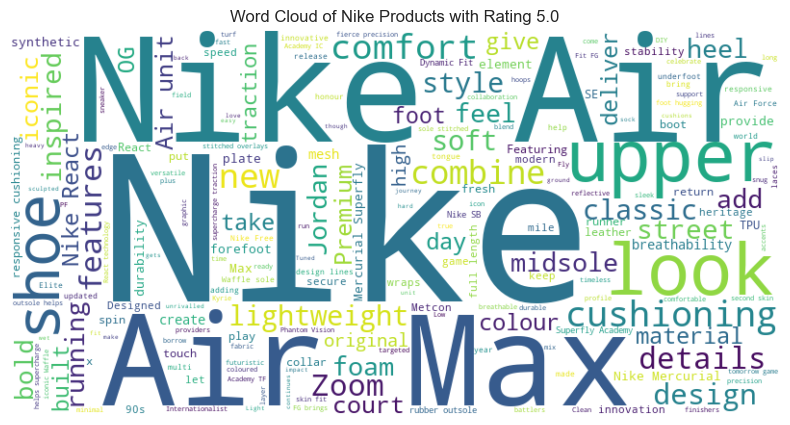

In [93]:
text = ' '.join(descriptions)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Nike Products with Rating 5.0')
plt.show()

In [109]:
adidas_rating_5 = adidas_rating[adidas_rating['Rating'] == 5.0]
descriptions_adi = adidas_rating_5['Description']
print("Descriptions of Adidas products with a rating of 5.0:")
for desc in descriptions_adi:
    print("- ", desc)

Descriptions of Adidas products with a rating of 5.0:
-  These women's neutral running shoes will get you on the road to your goals. A sandwich mesh upper offers lightweight breathability, while a seamless print overlay adds support for a stable stride. The midsole offers pillow-soft Cloudfoam cushioning that eases every stride.
-  These women's running-inspired shoes cradle your feet with a mesh upper and a Memory Foam footbed that conforms to the shape of your foot. Pillow-soft Cloudfoam cushioning in the one-piece midsole and outsole provides comfort that lasts all day long.
-  Fast and sleek. Ready to go. These women's running shoes feature a streamlined, low-profile design and pillow-soft Cloudfoam cushioning for plush landings. The mesh upper delivers a speedy look in fun colours and 3-Stripes.
-  The premium looking adidas Nebular 1.0 Running shoes for men crafted with Mesh overlays which make it lightweight. The breathable sandwich Mesh offer extended ventilation and comfort. L

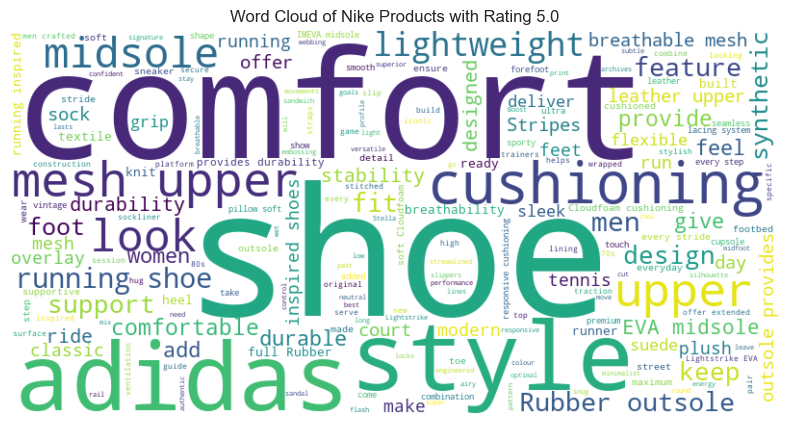

In [95]:
text = ' '.join(descriptions_adi)
wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('Word Cloud of Nike Products with Rating 5.0')
plt.show()